# Однофакторный дисперсионный анализ
Генотерапия позволяет корректировать работу дефективного гена, ответственного за развитие заболевания. В эксперименте сравнивалась эффективность четырёх различных типов терапии - А, B, C, D.
В исходной таблице:
Therapy - группа терапии.
expr - уровень экспрессии.

Нужно сравнить средний уровень экспрессии гена групп между собой.

Гипотеза H0 - средний уровень экспресси гена будет абсолютно одинаковый при использовании всех 4-х типов терапии.

In [2]:
#Импорты
import pandas as pd
from scipy import stats 
import matplotlib.pyplot as plt

In [3]:
#Загрузка датасета и привидение данных в читаемый вид. 
data = pd.read_csv('genetherapy.csv')
therapy_names = {
    'A': 'Терапия А',
    'B': 'Терапия B',
    'C': 'Терапия C',
    'D': 'Терапия D'
    }
data = data.replace(therapy_names)

In [11]:
#Разбили данные по группам и посчитали 
A = data[data["Therapy"] == "Терапия А"]["expr"]
B = data[data["Therapy"] == "Терапия B"]["expr"]
C = data[data["Therapy"] == "Терапия C"]["expr"]
D = data[data["Therapy"] == "Терапия D"]["expr"]
F, p = stats.f_oneway(A, B, C, D)
print("F-значение групп: ", F)
print("p-value такого F-значения: ",p)
print("Значит как минимум 2 средних значимо отличаются между собой")

F-значение групп:  8.03730248114399
p-value такого F-значения:  0.00015249722895229536
Значит как минимум 2 средних значимо отличаются между собой


In [6]:
#Подготовим данные для графика доверительных интервалов. Посчитаем среднее, стандартную ошибку и колличество элементов.
groups = data.groupby('Therapy')['expr'].agg(['mean','sem','count'])
groups.columns = ['Mx','SE','N']
groups['interval'] = 2 * groups['SE']
groups = groups.sort_values(by = ['Mx'], ascending=False)
groups

,Mx,SE,N,interval
Therapy,,,,
Терапия А,99.733333,1.075558,15,2.151116
Терапия B,98.800000,1.521904,15,3.043807
Терапия C,94.400000,1.340931,15,2.681861
Терапия D,92.333333,0.964447,15,1.928895


In [7]:
#Межгрупповые и внутригрупповые суммы квадратов
ssb_df = len(groups) - 1
ssw_df = data.shape[0] - len(groups)

F ( 3 , 56 ) = 8.04 , p = 0.0002


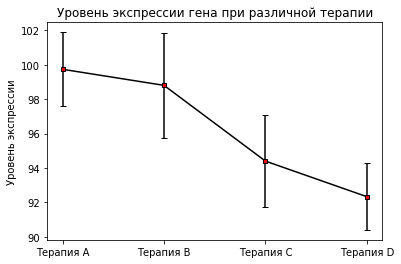

In [8]:
#Сам график
plt.title('Уровень экспрессии гена при различной терапии')
plt.ylabel('Уровень экспрессии')
plt.errorbar(x=groups.index, y=groups['Mx'], yerr = groups['interval'],
                        color="black", capsize=3, marker="s", markersize=4, mfc="red", mec="black")
print('F (',ssb_df,',',ssw_df,') =',round(F,2),", p =",round(p,4))

Значит, терапии A и B каким то образом значимо справляются с терапией чем группы C и D.
Попробуем дальше возпользоваться критерием Тьюки для того, чтобы расчитать доверительный интервал разницы между всеми парами групп терапии.

Таким образом мы сможем понять какая конкретная пара групп значимо различается между собой.

In [9]:
#Импорт библиотеки для расчета и передача данных для анализа в метод множественного сравнения
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
MultiComp = MultiComparison(data['expr'], data['Therapy'])
print(MultiComp.tukeyhsd().summary())

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower    upper  reject
-----------------------------------------------------------
Терапия B Терапия C     -4.4 0.0712  -9.0628  0.2628  False
Терапия B Терапия D  -6.4667 0.0029 -11.1294 -1.8039   True
Терапия B Терапия А   0.9333    0.9  -3.7294  5.5961  False
Терапия C Терапия D  -2.0667 0.6296  -6.7294  2.5961  False
Терапия C Терапия А   5.3333 0.0189   0.6706  9.9961   True
Терапия D Терапия А      7.4  0.001   2.7372 12.0628   True
-----------------------------------------------------------


Text(0.5, 1.0, '95% family-wise confidence level')

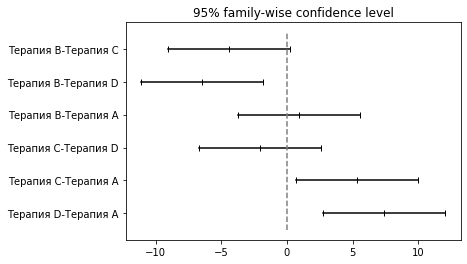

In [11]:
Tukey_data = MultiComp.tukeyhsd()._results_table.data
Tukey_df = pd.DataFrame(Tukey_data[1:], columns=Tukey_data[0])

Tukey_df['category'] = Tukey_df['group1'] + ['-'] * len(Tukey_df) + Tukey_df['group2']
Tukey_df['orderby'] = range(len(Tukey_df), 0, -1)

for lower, upper, meandiff, y in zip(Tukey_df['lower'], Tukey_df['upper'], Tukey_df['meandiff'], Tukey_df['orderby']):
    plt.plot((lower, upper),(y, y), '|-', color='black')
    plt.plot(meandiff, y ,'|-', color='black')
    
plt.yticks(Tukey_df['orderby'], Tukey_df['category'])
plt.vlines(0, Tukey_df['orderby'].min() - 0.5, Tukey_df['orderby'].max() + 0.5, linestyles='dashed', color='gray')
plt.title('95% family-wise confidence level')

Благодаря критерию Тьюки видно, что под вопрос встала значимость различий между парами B и C. p-value этой пары тоже находится на границе и составляет 0,07. Это больше 0.05, значит мы не можем отклонить нулевую гипотезу в данном случае.

Значимо отличаются следующие пары:
- B и D
- A и С
- A и D